In [1]:
import networkx as nx
import matplotlib
import matplotlib.pylab as plt
import math
# from networkx.drawing.nx_pydot import write_dot

In [2]:
mouse_retina = nx.read_graphml("mouse_retina_1.graphml")
mouse_retina = mouse_retina.to_undirected()

In [3]:
mouse_retina = nx.Graph(mouse_retina) 

In [4]:
for component in list(nx.connected_components(mouse_retina)):
    if(len(component) < 50):
        for node in component:
            mouse_retina.remove_node(node)

F:\Anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


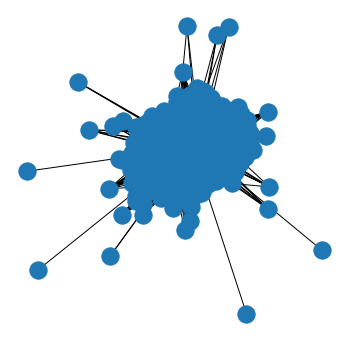

In [5]:
plt.figure(figsize=(6,6))
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
plt.show(nx.draw(mouse_retina))

In [6]:
print("Number of nodes: " + str(len(mouse_retina.nodes())))
print("Number of edges: "  + str(len(mouse_retina.edges())))

Number of nodes: 1076
Number of edges: 90811


In [2]:
uc_network = nx.read_edgelist("UC_network.txt")

In [3]:
for component in list(nx.connected_components(uc_network)):
    if(len(component) < 50):
        for node in component:
            uc_network.remove_node(node)

count = 0
mapng = {}
for n in uc_network.nodes():
    mapng[n] = count
    count+=1
uc_network = nx.relabel_nodes(uc_network, mapng)

F:\Anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


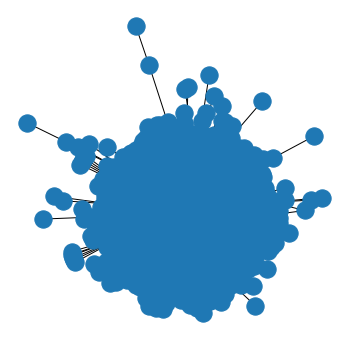

In [4]:
plt.figure(figsize=(6,6))
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
plt.show(nx.draw(uc_network))

In [5]:
print("Number of nodes: " + str(len(uc_network.nodes())))
print("Number of edges: "  + str(len(uc_network.edges())))

Number of nodes: 1893
Number of edges: 15728


In [330]:
def Q(G, C):
    m = len(G.edges())
    outside = 1/(2*m)
    inside = 0
    for i in G.nodes():
        for j in G.nodes():
            Aij = G.number_of_edges(i, j)
            k = G.degree(i) * G.degree(j)
            kronecker_delta = 1 if C[i] == C[j] else 0
            inside += (Aij - (k/(2*m)))*(kronecker_delta)
    return outside * inside 

In [331]:
def delta_Q(v, C, G):
    sigma_in = 0 
    for edge in G.edges():
        if(C[v] == C[edge[0]] and C[v] == C[edge[1]]):
            sigma_in += 1
    ######################################
    k_in = 0
    for neigh in G.neighbors(v):
        if(C[v] == C[neigh]):
            k_in += 1
    ######################################
    sigma_tot = 0
    for edge in G.edges():
        if(C[edge[0]] == C[v] and C[v] != C[edge[1]]):
            sigma_tot += 1
        elif(C[edge[1]] == C[v] and C[v] != C[edge[0]]):
            sigma_tot += 1
    ######################################      
    m = len(G.edges)
    first_term = (((sigma_in + k_in)/(2*m)) - (((sigma_tot + G.degree(v))/(2*m))**2))
    second_term = (sigma_in/(2*m)) - ((sigma_tot/(2*m))**2) - ((G.degree(v)/(2*m))**2)
    return first_term - second_term

In [332]:
def MoveNodes(G):
    C = {}
    for idx, n in enumerate(G.nodes()):
        C[n] = idx
    nodes_moved = True
    while nodes_moved:
        nodes_moved = False
        for v in G.nodes():
            best_q = delta_Q(v, C, G)
            best_c = C[v]
            for neighbor in G.neighbors(v):
                C_temp = C
                C_temp[v] = C[neighbor]
                gain_q = delta_Q(v, C_temp, G)
                if best_q < gain_q and gain_q > 0:
                    best_q = gain_q
                    best_c = C[neighbor]
                    nodes_moved = True
            C[v] = best_c
    return C 
        

In [339]:
def Aggregate(G, C, Original_C):
    G_prime = nx.MultiDiGraph()
    communities = []
    for n, c in C.items():
        for k, v in Original_C.items():
            if (v == n):
                Original_C[k] = c
        if c not in communities:
            communities.append(c)
            
    G_prime.add_nodes_from(communities)
    
    for n1, n2 in G.edges():
        G_prime.add_edge(C[n1], C[n2])

    print("Number of nodes: {}".format(len(G_prime.nodes())))
    
    return G_prime, Original_C

In [340]:
def louvain_algorithm(G):
    G_prime = G
    C = {}
    Original_C = {}
    for idx, n in enumerate(G_prime.nodes()):
        Original_C[n] = idx
        C[n] = idx
    q = -math.inf
    r = 1
    print("Original Graph Q Score: {}".format(Q(G_prime, C)))
    G_best = G_prime
    C_best = C
    Orig_best = {}
    while q < Q(G_prime, C):
        G_best = G_prime
        C_best = C
        Orig_best = {}
        for k, v in Original_C.items():
            Orig_best[k] = v
        print("Round: {}".format(r))
        q = Q(G_prime, C)
        print("Modularity Score: {}".format(q))
        C = MoveNodes(G_prime)
        G_prime, Original_C = Aggregate(G_prime, C, Original_C)
        c_new = {}
        for idx, n in enumerate(G_prime.nodes()):
            c_new[n] = idx
        C = c_new
        drawGz(G_prime, C)
        r+=1
        print("Last Modularity Score: {}".format(Q(G_prime , C)))
    return G_best, C_best, Orig_best

In [341]:
Gg = nx.gnp_random_graph(100, 0.15, 9)

F:\Anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


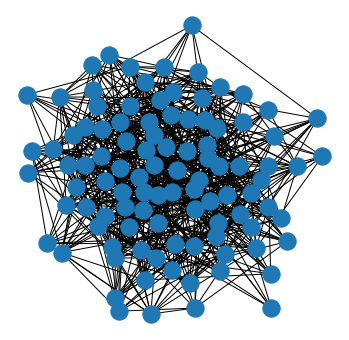

In [342]:
plt.figure(figsize=(6,6))
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
plt.show(nx.draw(Gg))

In [343]:
import random
def drawGz(G,z):
    r = lambda: random.randint(0,255)
    colors = []
    for i in range(0, 300):
        c = '#%02X%02X%02X' % (r(),r(),r())
        if c not in colors:
            colors.append(c)
    node_colors = []
    for i in G.nodes():
        node_colors.append(colors[int(z[i])])
    nsize  = 600
    flabel = True

    if G.order() > 50:
        nsize  = 100
        flabel = False
        
    nx.draw_networkx(G,with_labels=flabel,node_size=nsize,width=2,node_color=node_colors)
    limits=plt.axis('off')
    plt.savefig('UC_Network_POST.pdf', dpi=1000)
    plt.figure(figsize=(20,20)) 
    plt.show() 

    return

Original Graph Q Score: 0.0585039876948052
Round: 1
Modularity Score: 0.0585039876948052
Number of nodes: 214


F:\Anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


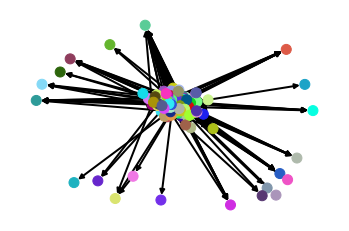

<Figure size 1440x1440 with 0 Axes>

Last Modularity Score: 0.13133456604015467
Round: 2
Modularity Score: 0.13133456604015467


In [ ]:
G, Final_c, orig_c = louvain_algorithm(uc_network)
# G, Final_c, orig_c = louvain_algorithm(Gg)

# nx.draw(G)
# print("*{}".format(len(Final_c)))
# print("**{}".format(Final_c))
# print("***{}".format(orig_c))
lst = []
for v in orig_c.values():
    if v not in lst:
        lst.append(v)
# print("****{}".format(lst))

z = {}
for k, v in orig_c.items():
    z[k] = Final_c[v]
# print("*****{}".format(z))



F:\Anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


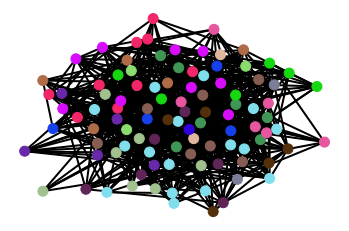

<Figure size 1440x1440 with 0 Axes>

In [345]:
drawGz(Gg, z)